# 題目： 如何用 DTW 在市場趨勢下時逆向獲利

> 本Jupyter Notebook分兩部分，前半部為市場指標的研究與分析，後半部是英雄股的研究與分析


### 1. 市場指標 - DTW熱力圖、不同時長周期的DTW值、DTW趨勢圖
```
<市場指標> 假設 一天交易時數 6小時

時間軸：

一年(2 day) 5*52/2=130 

半年(1 day) 22*6=132

三個月(3hr ) 2*22*3=132

一個月(1hr) 6*22=132

一週（15min)  4*6*5=120
```
### 2. 英雄股
```
<英雄股> 假設 一天交易時數 6小時

時間軸：

1天 3分鐘   （120） 

3天 10分鐘 （108）

1週 15分鐘 （120）
```




In [1]:
# !pip install -U pip
# !pip install yfinance
# !pip install numpy_ext
# !pip install dtaidistance
# !pip install -U matplotlib

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import io
import math
import time
import sys
import datetime
import numpy as np
import pandas as pd
from numpy_ext import rolling_apply
import re
from dtaidistance import dtw
from matplotlib.axis import Tick
from dtaidistance import dtw_visualisation as dtwvis
import warnings


numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


# 一、前置處理

## 1. 必要函數 - 歸一化

> 因為兩數列的數值差會對DTW算法有影響，因此我們將股票做歸一化，將不同價錢區間的股票全部縮放到0-1之間，以消除數值差對DTW的差異，讓20000美金的BTC跟1800美金的ETH可以做比較。

### 公式:

$x_{new} = x_i - x_{min} / x_{max} - x_{min}$

In [3]:
def minmax(df):
    """
    Args:
        df(dataframe, or np.array) : 輸入的必須是可以使用.min()與.max()
    
    Return:
        df_minmax(dataframe) : 完成歸一化的dataframe
    """
    df_minmax = (df - df.min())/(df.max() - df.min())
    return df_minmax

## 2. Dynamic Time Wraping (DTW)

> 因為比較時間序列很常遇到的情況是兩序列有相位差或是相同的走勢但是有時間前後差異，像加密貨幣很多時候都是BTC先漲，然後ETH或其他的小幣再跟漲，若這時用傳統的計算方式，如Euclidean 或 MAPE，則無法看出這種前後的趨勢，而DTW則可以，DTW的運作原理為將兩時間序列連連看，看有沒有相似的走勢，上漲連到上漲，下跌連到下跌，若無對應則連到旁邊的點，並計算有多少點被迫連到旁邊，以取得DTW值

更詳細的內容可以參考: [DTW(dynamic time wraping)算法浅析以及改进](https://zhuanlan.zhihu.com/p/72672298)

In [4]:
s1 = np.array([0., 0, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 0])
s2 = np.array([0., 1, 2, 3, 1, 0, 0, 0, 2, 1, 0, 0, 0])
d = dtw.distance(s1, s2)
d

1.4142135623730951

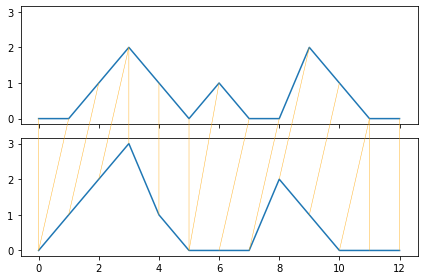

In [5]:
s1 = np.array([0., 0, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 0])
s2 = np.array([0., 1, 2, 3, 1, 0, 0, 0, 2, 1, 0, 0, 0])
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path)
plt.show()

## 3. 數據來源
> 本研究資料皆由yahoo finance所提供的yfinance API取得，yahoo finance提供許多股票、指數、大眾商品等的價格與交易量等資訊，且完全免費，最小單位也可到1分鐘，是很好的資料源。

In [6]:
data = yf.download(  
        tickers = '^DJI',
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = '1mo',
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = '1d',
        group_by = 'ticker',
        auto_adjust = True,
        prepost = False,
        threads = True,
        proxy = None
    )

[*********************100%***********************]  1 of 1 completed


# 一、市場指標 


## 1. DTW熱力圖
> 將多個指數或大眾商品以公式計算出DTW值，並將其畫成熱力圖。

### 用法
```
函數主要參數為一串字串，為大宗商品或指數代碼之字串，並以空格隔開如:

"^DJI ^IXIC YM=F NQ=F BTC=F ETH=F GC=F CL=F ^HSI 000001.SS ^KS11 ^TWII DX-Y.NYB"
```

In [7]:
def heatmap_hero(wanted_string, period='1mo', interval='1d', annot= True, xrotation = 0, yrotation = 0):
    """
    Args:
        wanted_string(str) : 格式為"股票代碼 股票代碼...."，如"^DJI ^IXIC YM=F NQ=F BTC=F ETH=F GC=F CL=F ^HSI"
        period(str) : 總時間長
        interval(str) : 資料時間間隔(最小單位)
        annot(bool) : 熱力圖的annotation
        xrotation、yrotation(float) : 標籤旋轉角度
    Return:
        None
        會畫出一張熱力圖
    """
    
    data = yf.download(  
        tickers = wanted_string,
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = period,
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = interval,
        group_by = 'ticker',
        auto_adjust = True,
        prepost = False,
        threads = True,
        proxy = None
    )
    series = []
    save_stock = []
    
    for i in wanted_string.split(" "):
        if len(minmax(data[(f'{i}',   'Close')].dropna()).values) > 0:
            series.append(minmax(data[(f'{i}',   'Close')].dropna()).values)
            save_stock.append(i)

    ds = dtw.distance_matrix(series)
    ds2 = np.flip(ds, 0)

    plt.figure(figsize= (20, 20))
    ax = plt.gca()
    sns.heatmap(ds2, annot= annot, square=True, fmt='.3f', annot_kws={'size': 15}, cmap ='RdBu', cbar_kws={"shrink": 0.824})
    ax.set_yticklabels(np.array(save_stock)[::-1], rotation = yrotation)
    ax.set_xticklabels(save_stock,  rotation = xrotation)
    plt.title('Similarity - DTW', fontsize = 20)
    plt.xlabel('Powered by Team SuperNormal', horizontalalignment='right', x=1.15, fontsize = 15)
    plt.show()

[*********************100%***********************]  13 of 13 completed


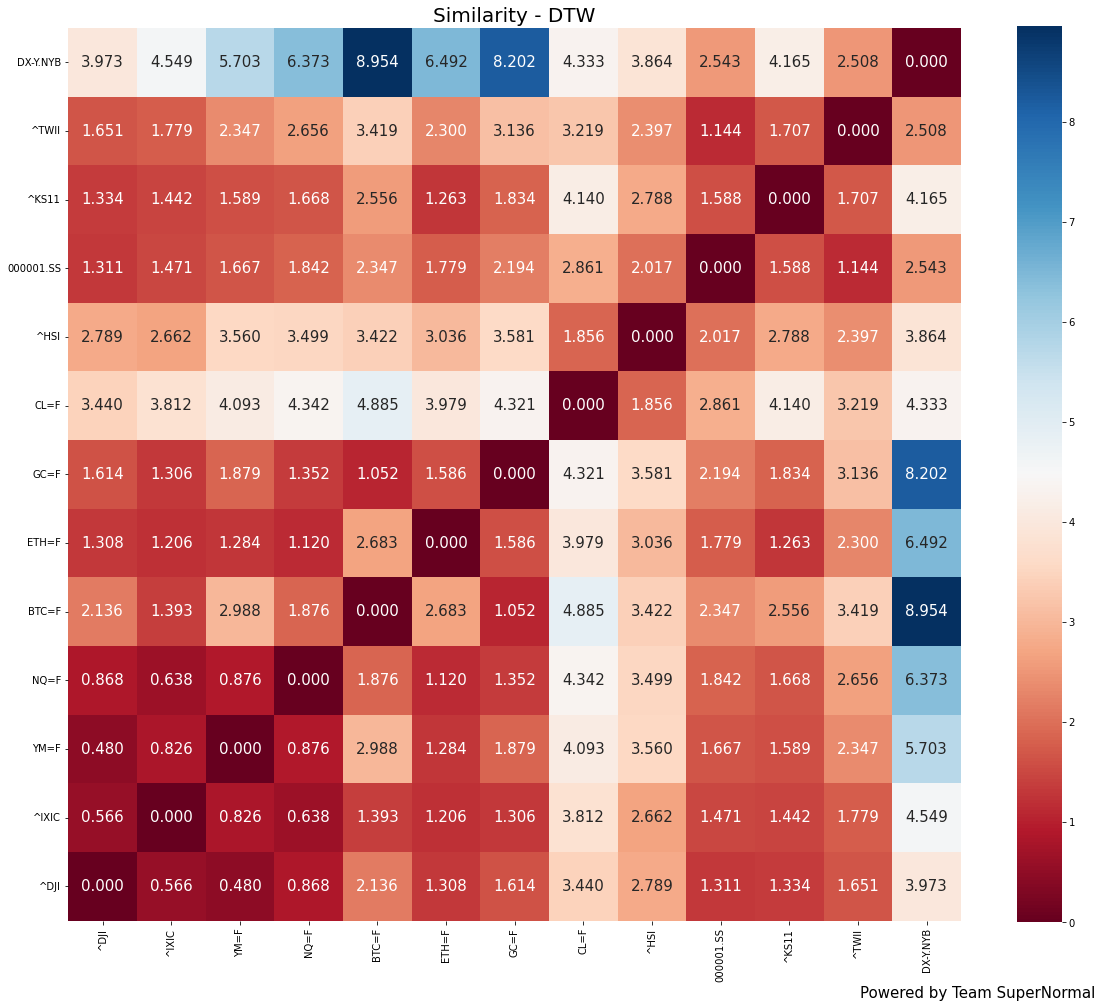

In [8]:
wanted = "^DJI ^IXIC YM=F NQ=F BTC=F ETH=F GC=F CL=F ^HSI 000001.SS ^KS11 ^TWII DX-Y.NYB"

heatmap_hero(wanted, period='1mo', interval='1h', xrotation= 90, yrotation=0)

## 2. 不同時長周期的DTW值
> 在不同時長之下，比較一或多對的數據對的DTW值，以用來查看在不同時間軸下的DTW值

### 用法:
```
股票與股票之間用 "-" 串起，組間用"&"串起，如下:

"^DJI-^IXIC & ^KS11-000001.SS & ^TWII-^KS11 & BTC=F-ETH=F"
```

In [9]:
def multi_time(string):
    """
    Args:
        wanted_string(str) : 格式為"股票代碼-股票代碼 & 股票代碼-股票代碼"，如"^DJI-^IXIC & ^KS11-000001.SS & ^TWII-^KS11 & BTC=F-ETH=F & ...."

    Return:
        df(DataFrame) : 不同週期的DTW圖
    """

    # 時間段
    today = pd.to_datetime('today').replace(microsecond= 0)
    time1w = datetime.timedelta(days=7)
    time1mo = datetime.timedelta(days=30)
    time3mo = datetime.timedelta(days=90)
    time6mo = datetime.timedelta(days=180)
    time12mo = datetime.timedelta(days=365)
    
    # Stock process
    want_list = string.split('&')
    want_cup_list = [x.strip() for x in want_list]
    want_list = np.array([x.split("-") for x in want_cup_list])
    want_list = list(set(want_list.ravel()))
    stock_string = " ".join(want_list)
    

    

    # get data
    data7 = yf.download(tickers = stock_string, period = '7d', interval = "15m", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
    data30 = yf.download(tickers = stock_string, period = '1mo', interval = "1h", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
    data90 = yf.download(tickers = stock_string, period = '3mo', interval = "1h", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
    data180 = yf.download(tickers = stock_string, period = '6mo', interval = "1d", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
    data365 = yf.download(tickers = stock_string, period = '1y', interval = "1d", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
    
    # time list
    time_delt = [time1w, time1mo, time3mo, time6mo, time12mo]

    # built first dataframe
    promote = want_cup_list[0].replace("^", "")
    lists = [[promote], ['DTW']] #'Time Period', 
    index = pd.MultiIndex.from_product(lists)
    df = pd.DataFrame(columns= index)

    # 計算
    for groups in want_cup_list:
        stock = groups.split("-")
        promote = groups.replace("^", "")

        tt_list = []
        distance_list = []
        corr = []
        for tt in time_delt:

            if tt.days == 7:
                ss = data7.loc[:, [(stock[0],   'Close'), (stock[1],   'Close')]]
                ss = ss.dropna()

                s1 = minmax(ss[(stock[0],   'Close')]).values
                s2 = minmax(ss[(stock[1],   'Close')]).values

                distance = dtw.distance(s1, s2)
                distance_list.append(round(distance, 3))
                pear = np.corrcoef(s1, s2)[0, 1]
                corr.append(round(pear, 3))
         
            elif tt.days == 30:
                ss = data30.loc[:, [(stock[0],   'Close'), (stock[1],   'Close')]]
                ss = ss.resample('1h', closed='right', label = 'left').last().dropna()

                s1 = minmax(ss[(stock[0],   'Close')]).values
                s2 = minmax(ss[(stock[1],   'Close')]).values
                distance = dtw.distance(s1, s2)
                distance_list.append(round(distance, 3))
                pear = np.corrcoef(s1, s2)[0, 1]
                corr.append(round(pear, 3))
         
            elif tt.days == 90:
                ss = data90.loc[:, [(stock[0],   'Close'), (stock[1],   'Close')]]
                ss = ss.resample('3h', closed='right', label = 'right').last().dropna()

                s1 = minmax(ss[(stock[0],   'Close')]).values
                s2 = minmax(ss[(stock[1],   'Close')]).values
                distance = dtw.distance(s1, s2)
                distance_list.append(round(distance, 3))
                pear = np.corrcoef(s1, s2)[0, 1]
                corr.append(round(pear, 3))
        
            elif tt.days == 180:
                ss = data180.loc[:, [(stock[0],   'Close'), (stock[1],   'Close')]]
                ss = ss.dropna()

                s1 = minmax(ss[(stock[0],   'Close')]).values
                s2 = minmax(ss[(stock[1],   'Close')]).values
                distance = dtw.distance(s1, s2)
                distance_list.append(round(distance, 3))
                pear = np.corrcoef(s1, s2)[0, 1]
                corr.append(round(pear, 3))
        
            elif tt.days == 365:
                ss = data365.loc[:, [(stock[0],   'Close'), (stock[1],   'Close')]]
                ss = ss.dropna().resample('2D', closed='right', label = 'right').last().dropna()

                s1 = minmax(ss[(stock[0],   'Close')]).values
                s2 = minmax(ss[(stock[1],   'Close')]).values
                distance = dtw.distance(s1, s2)
                distance_list.append(round(distance, 3))
                pear = np.corrcoef(s1, s2)[0, 1]
                corr.append(round(pear, 3))
              

        df.loc[:, (promote, 'DTW')] = distance_list
        df.loc[:, (promote, 'Pearson')] = corr
        
    # set index 
    df['Period'] = ['7', '30', '90', '180', '365']
    df = df.set_index('Period')
   
    return df

In [10]:
wanted = "^DJI-^IXIC & ^KS11-000001.SS & ^TWII-^KS11 & BTC=F-ETH=F"
a = multi_time(wanted)
a

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed


DJI-IXIC         KS11-000001.SS         TWII-KS11         BTC=F-ETH=F  \
            DTW Pearson            DTW Pearson       DTW Pearson         DTW   
Period                                                                         
7         0.437   0.975          2.765   0.093     1.267   0.875       1.333   
30        0.565   0.904          1.379   0.517     1.582   0.648       2.683   
90        0.574   0.963          2.598  -0.578     0.564   0.809       4.633   
180       0.740   0.951          1.661  -0.384     0.579   0.937       0.734   
365       0.722   0.946          1.667   0.739     1.011   0.774       0.523   

                
       Pearson  
Period          
7        0.964  
30       0.834  
90       0.719  
180      0.970  
365      0.970

## 3. DTW趨勢圖
> 藉由滾動計算的方法，計算出兩股票或指數的DTW走勢，以判斷兩者為越來越相似還是越來越偏離彼此

### 用法 :　


similary('股票代號 股票代號 $ period')，如 :

similary('^HSI 000001.SS $ 6mo')


### 允許 period :
`7d 1mo 3mo 6mo 1y 及整數年`

In [11]:
def similary(stock_wanted:str):
    """
    Args:
        wanted_string(str) : 格式為'股票代碼 股票代碼 $ 6mo'，如"^HSI 000001.SS $ 6mo"

    Return:
        None，但是會畫出DTW趨勢圖
    """
        
    warnings.filterwarnings("ignore")
    stock = [x.strip() for x in stock_wanted.split("$")]
    time_string = re.search(r'(\d+)(\w+)', stock[1])


    if stock[1] == '7d':
        data365_tem = yf.download(tickers = stock[0], period = '14d', interval = "15m", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
        data365 = data365_tem.dropna()
        day = 7
    elif stock[1] == '1mo':
        data365_tem = yf.download(tickers = stock[0], period = '2mo', interval = "1h", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
        data365 = data365_tem.resample('1h', closed='right', label = 'left').last().dropna()
        day = 30
    elif stock[1] == '3mo':
        data365_tem = yf.download(tickers = stock[0], period = '6mo', interval = "1h", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None).dropna()
        data365 = data365_tem.resample('3h', closed='right', label = 'right').last().dropna()
        day = 90
    elif stock[1] == '6mo':
        data365_tem = yf.download(tickers = stock[0], period = '1y', interval = "1d", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
        data365 = data365_tem.dropna()
        day = 180
    elif stock[1] == '1y':
        data365_tem = yf.download(tickers = stock[0], period = '2y', interval = "1d", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None).dropna()
        data365 = data365_tem.resample('2D', closed='right', label = 'right').last().dropna()
        day = 365
    elif time_string.group(2) == 'y':
        num = int(time_string.group(1)) + 1
        period = str(num) + time_string.group(2)
        data365_tem = yf.download(tickers = stock[0], period = period, interval = "1wk", group_by = 'ticker', auto_adjust = True,  prepost = False, threads = True, proxy = None)
        data365 = data365_tem.dropna()
        day = 365
    else:
        print("Type Error")
        return 0

    def masscenter(s1, s2):
        ss1 = minmax(s1)
        ss2 = minmax(s2)
        return dtw.distance(ss1, ss2, use_pruning=True)

    # string
    ff = re.search(r'(\S+)\s+(\S+)', stock[0])
    

    dfs = data365.loc[:, [(ff.group(1),   'Close'), (ff.group(2),   'Close')]]
    
    if time_string.group(2) != 'y' or stock[1] == '1y':
        window = int(len(dfs)/2)
        dfs['y'] = rolling_apply(masscenter, window, dfs[(ff.group(1),   'Close')].values.astype(np.double), dfs[(ff.group(2),   'Close')].values.astype(np.double))

    elif time_string.group(2) == 'y':      
        window = 52
        dfs['y'] = rolling_apply(masscenter, window, dfs[(ff.group(1),   'Close')].values.astype(np.double), dfs[(ff.group(2),   'Close')].values.astype(np.double))
    
    else:
        print("Type Error")
        return 0

    data_his = dfs.dropna()
    data_his.loc[:, [(ff.group(1), 'Close'), (ff.group(2), 'Close')]] = minmax(data_his.loc[:, [(ff.group(1), 'Close'), (ff.group(2), 'Close')]])
    

    fig = plt.figure(figsize=(12, 12))
    rect = fig.patch
    rect.set_facecolor('white')
    grid = plt.GridSpec(4, 3, figure= fig, hspace= 0)
    plt.subplot(grid[0:3, 0:3])
    plt.title(f'{stock[1]} Similarity History Plot (DTW)', fontsize = 15)
    plt.plot(data_his.index, data_his[(ff.group(1), 'Close')], label = ff.group(1).replace("^", ""))
    plt.plot(data_his.index, data_his[(ff.group(2), 'Close')], label = ff.group(2).replace("^", ""))
    plt.legend(fontsize = 15)
    ax = plt.gca()
    ax.xaxis.set_ticks([])
    
    # plt.xticks(rotation= -10)
    plt.subplot(grid[3:4, 0:3])
    ax1 = plt.gca()
    ax.yaxis.tick_right() 
    plt.plot(data_his.index, data_his['y'], c ='black', label = f'DTW ({day})')
    plt.legend(fontsize = 15)
    plt.xlabel('Powered by Team SuperNormal', horizontalalignment='right', x=1.05, fontsize = 13)
    plt.show()

[*********************100%***********************]  2 of 2 completed


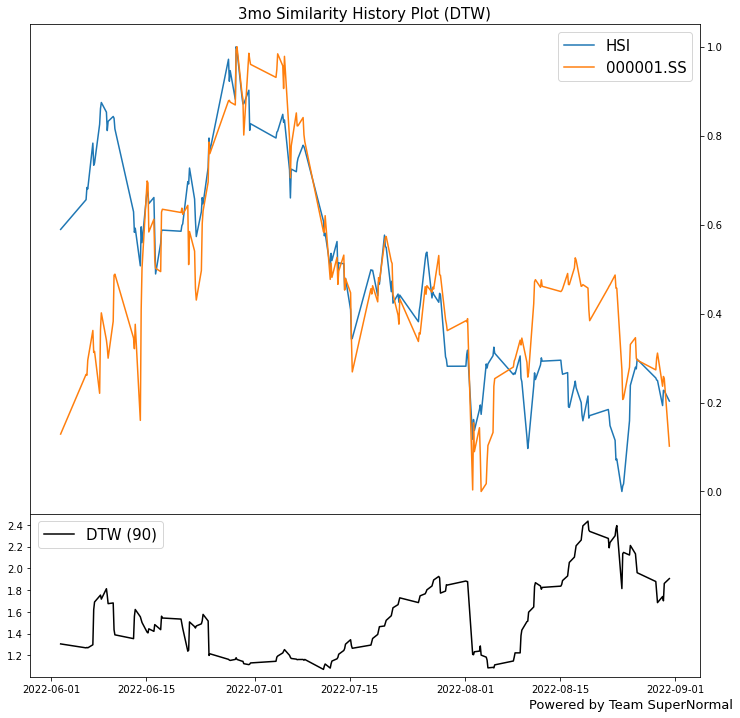

In [12]:
similary('^HSI 000001.SS $ 3mo')

[*********************100%***********************]  2 of 2 completed


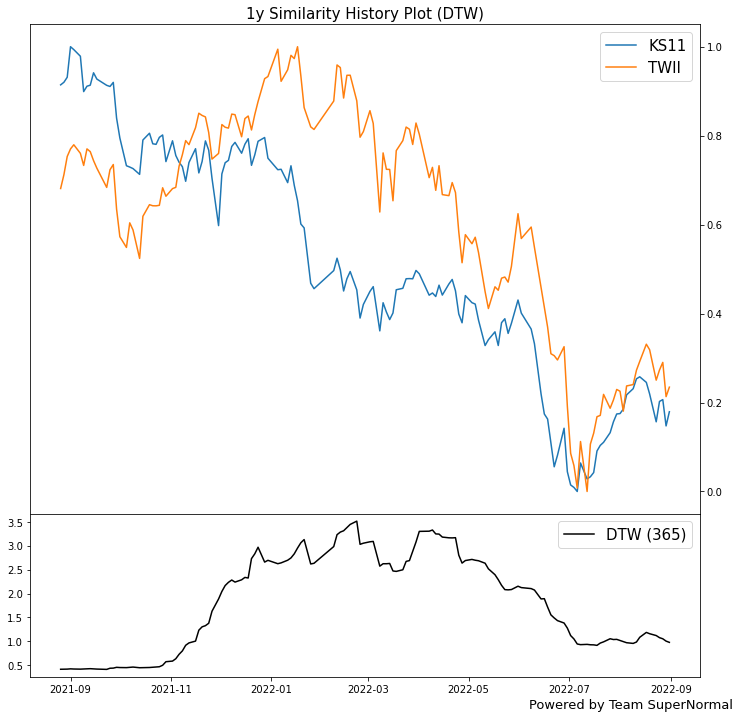

In [13]:
similary('^KS11 ^TWII $ 1y')

# 二、英雄股

> 我們使用網路爬蟲批次取得yahoo finance的股票資料，並使用前面有使用過的熱力圖，但多了排序的步驟，並取與大盤差異最大的數個股票，並將他們的趨勢畫出來。

### 注意事項: 當股票數過多或是時間間隔太小(資料筆數過多)，易造成計算時間太長

In [14]:
import requests
from bs4 import BeautifulSoup

In [15]:
# 網路爬蟲
try:
    first = 'https://finance.yahoo.com/screener/unsaved/aac9e741-4e11-4356-b365-89e06d7f6909?count=100&offset=0'
    first1 = 'https://finance.yahoo.com/screener/unsaved/aac9e741-4e11-4356-b365-89e06d7f6909?count=100&offset=25'
    second = 'https://finance.yahoo.com/screener/unsaved/aac9e741-4e11-4356-b365-89e06d7f6909?count=100&offset=50'
    second1 = 'https://finance.yahoo.com/screener/unsaved/aac9e741-4e11-4356-b365-89e06d7f6909?count=100&offset=75'
    third = 'https://finance.yahoo.com/screener/unsaved/aac9e741-4e11-4356-b365-89e06d7f6909?count=100&offset=100'
    third1 = 'https://finance.yahoo.com/screener/unsaved/aac9e741-4e11-4356-b365-89e06d7f6909?count=100&offset=125'
    fourth = 'https://finance.yahoo.com/screener/unsaved/aac9e741-4e11-4356-b365-89e06d7f6909?count=100&offset=150'
    fourth1 = 'https://finance.yahoo.com/screener/unsaved/aac9e741-4e11-4356-b365-89e06d7f6909?count=100&offset=175'
    url_list = [first, second, third, fourth, first1, second1, third1, fourth1]
    yahoo_all = []
    for url in url_list:
        page = requests.get(url, headers= { 'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.102 Safari/537.36 Edg/104.0.1293.70'})
        soup = BeautifulSoup(page.text, 'lxml')
        yahoo = soup.find('table', class_ = 'W(100%)').find_all('tr', class_ = 'simpTblRow Bgc($hoverBgColor):h BdB Bdbc($seperatorColor) Bdbc($tableBorderBlue):h H(32px) Bgc($lv2BgColor)')
        for stock in yahoo:
            yahoo_all.append(stock.find('a', {"data-test":"quoteLink"}).text)

    datas = " ".join(list(set(yahoo_all)))
    dji_datas = '^DJI ' + datas
    ixic_datas = '^IXIC ' + datas

except:
    stock_list = ['RTX', 'JNJ', 'PEP', 'NVDA', 'BACHF', 'CICHY', 'NVSEF', 'TD', 'BML-PG', 'ORCL', 'ABT', 'SHEL', 'NKE', 'WFC-PL', 'BUD', 'MPNGY', 'MA', 'SNEJF', 'CVS', 'CIHKY', 'BML-PJ', 'PFE', 'TTFNF', 'NEE', 'C-PJ', 'STOHF', 'PYPL', 'ABBV', 'WFC-PQ', 'DHR', 'CILJF', 'AMD', 'TSM', 'RYDAF', 'HDB', 'PTR', 'BMY', 'ACN', 'AAPL', 'PROSY', 'RHHBY', 'RLLCF', 'VZ', 'NSRGF', 'RHHVF', 'T', 'JPM', 'NONOF', 'TSLA', 'AMGN', 'BABAF', 'RY', 'AMT', 'BAC-PL', 'SPGI', 'AMZN', 'AAGIY', 'AAIGF', 'NSRGY', 'DGEAF', 'BABA', 'HESAY', 'DIS', 'BYDDF', 'AVGO', 'CVX', 'HBCYF', 'TMUS', 'CMWAY', 'TMO', 'SNY', 'BP', 'NVS', 'TOYOF', 'GS', 'ASML', 'BAC', 'CICHF', 'MDT', 'TXN', 'IBM', 'LIN', 'WFC-PY', 'HESAF', 'UNP', 'ADP', 'AXP', 'COP', 'ACGBY', 'BAC-PB', 'BYDDY', 'ADBE', 'WFC', 'INTC', 'GOOG', 'QCOM', 'RHHBF', 'LLY', 'MRK', 'MS', 'HSBC', 'TTE', 'ELV', 'EQNR', 'UL', 'BLK', 'RTNTF', 'BUDFF', 'LOW', 'SAPGF', 'PIAIF', 'UPS', 'DE', 'WFC-PR', 'BRK-B', 'SAP', 'SONY', 'LVMHF', 'LMT', 'BHP', 'COST', 'CAT', 'CBAUF', 'PBR', 'BML-PH', 'INTU', 'NFLX', 'BAC-PE', 'BHPLF', 'DEO', 'MCD', 'BAC-PK', 'BML-PL', 'HON', 'IDCBY', 'LRLCF', 'WFC-PC', 'LRLCY', 'KO', 'ASMLF', 'CRM', 'HD', 'PNGAY', 'BX', 'AZN', 'CSCO', 'UNLYF', 'C', 'TM', 'BACHY', 'NVO', 'LVMUY', 'CMCSA', 'PM', 'JDCMF', 'SCHW', 'XOM']
    datas = " ".join(stock_list)
    dji_datas = '^DJI ' + datas
    ixic_datas = '^IXIC ' + datas

In [16]:
# 包含排序功能的熱力圖
def heatmap_hero(wanted_string, period='1mo', interval='1d', annot= True, figsize= 20):
    """
    Args:
        wanted_string(str) : 格式為"股票代碼 股票代碼...."，如"^DJI ^IXIC YM=F NQ=F BTC=F ETH=F GC=F CL=F ^HSI"
        period(str) : 總時間長
        interval(str) : 資料時間間隔(最小單位)
        annot(bool) : 熱力圖的annotation
        figsize(int) : 字體大小
    Return:
        df_result(DataFrame) : 排序過後的熱力圖
        
    """
        
    data = yf.download(  
        tickers = wanted_string,
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = period,
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = interval,
        group_by = 'ticker',
        auto_adjust = True,
        prepost = False,
        threads = True,
        proxy = None
    )
    series = []
    save_stock = []
    for i in wanted_string.split(" "):
        if len(data[(f'{i}',   'Close')].dropna()) > 0:
            series.append(minmax(data[(f'{i}',   'Close')].dropna()).values)
            save_stock.append(i)
            
    ds = dtw.distance_matrix(series)
    ds2 = np.flip(ds, 0)
    a = np.array(save_stock)
    invert_a = np.array(save_stock)[::-1]
    df = pd.DataFrame()
    for num, i in enumerate(ds2):
        df[invert_a[num]] = i

    df.index = a
    df = df.T
    df_result = df.sort_values(by=a[0]).sort_values(by=a[0], axis= 1)
    
    plt.figure(figsize= (40, 40))
    ax = plt.gca()
    sns.heatmap(df_result.values, annot= False, square=True, fmt='.3f', annot_kws={'size': 15}, cmap ='RdBu', cbar_kws={"shrink": 0.824})
    ax.set_yticklabels(np.array(df_result.columns).ravel())
    ax.set_xticklabels(np.array(df_result.columns).ravel())
    plt.title('Similarity - DTW', fontsize = 20)
    plt.xlabel('Powered by Team SuperNormal', horizontalalignment='right', x=1.15, fontsize = 15)
    plt.show()
    return df_result

In [41]:
# 畫出16隻股票對大盤的走勢圖
def plot_hero_stock(wanted_string, period='1mo', interval='1d', figw= 20, figh= 20, threshold=70):
    """
    Args:
        wanted_string(str) : 格式為"股票代碼 股票代碼...."，如"^DJI ^IXIC YM=F NQ=F BTC=F ETH=F GC=F CL=F ^HSI"
        period(str) : 總時間長
        interval(str) : 資料時間間隔(最小單位)
        figw、figh(int) : 畫布的寬跟高
        threshold(int) : 股票資料比數大於多少才畫圖
    Return:
        None，但是會畫出16隻股票的圖
        
    """
        
    data = yf.download(  
        tickers = wanted_string,
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = period,
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = interval,
        group_by = 'ticker',
        auto_adjust = True,
        prepost = False,
        threads = True,
        proxy = None
    )
    a = 1
    stocks = wanted_string.split(" ")
    plt.figure(figsize= (figw, figh))
    for k, i in enumerate(stocks):
        if len(data[(f'{i}',   'Close')].dropna()) > threshold:
            if k > 0:
                plt.subplot(4, 4, a)
    #             print(data[f'{i}'].dropna().index)
                plt.plot(np.arange(0, len(minmax(data[(f'{i}',   'Close')].dropna()))), minmax(data[(f'{i}',   'Close')].dropna()), label= "{}".format(i))
                plt.plot(np.arange(0, len(minmax(data[(stocks[0],   'Close')].dropna()))), minmax(data[(stocks[0],   'Close')].dropna()), label= "{}".format(stocks[0]))
                plt.legend(fontsize= 16, title= '{}/{}'.format(period, interval))
                plt.xticks([])
                
                
                a = a+1
                if a > 16: 
                    break
           
    plt.show()

### 已準備資料(爬蟲爬下來的)
1. dji_datas : 道瓊斯指數與美國前百大市值的公司
2. ixic_datas : 那斯達克指數與美國前百大市值的公司

[*********************100%***********************]  160 of 160 completed

1 Failed download:
- ACGBF: No data found for this date range, symbol may be delisted


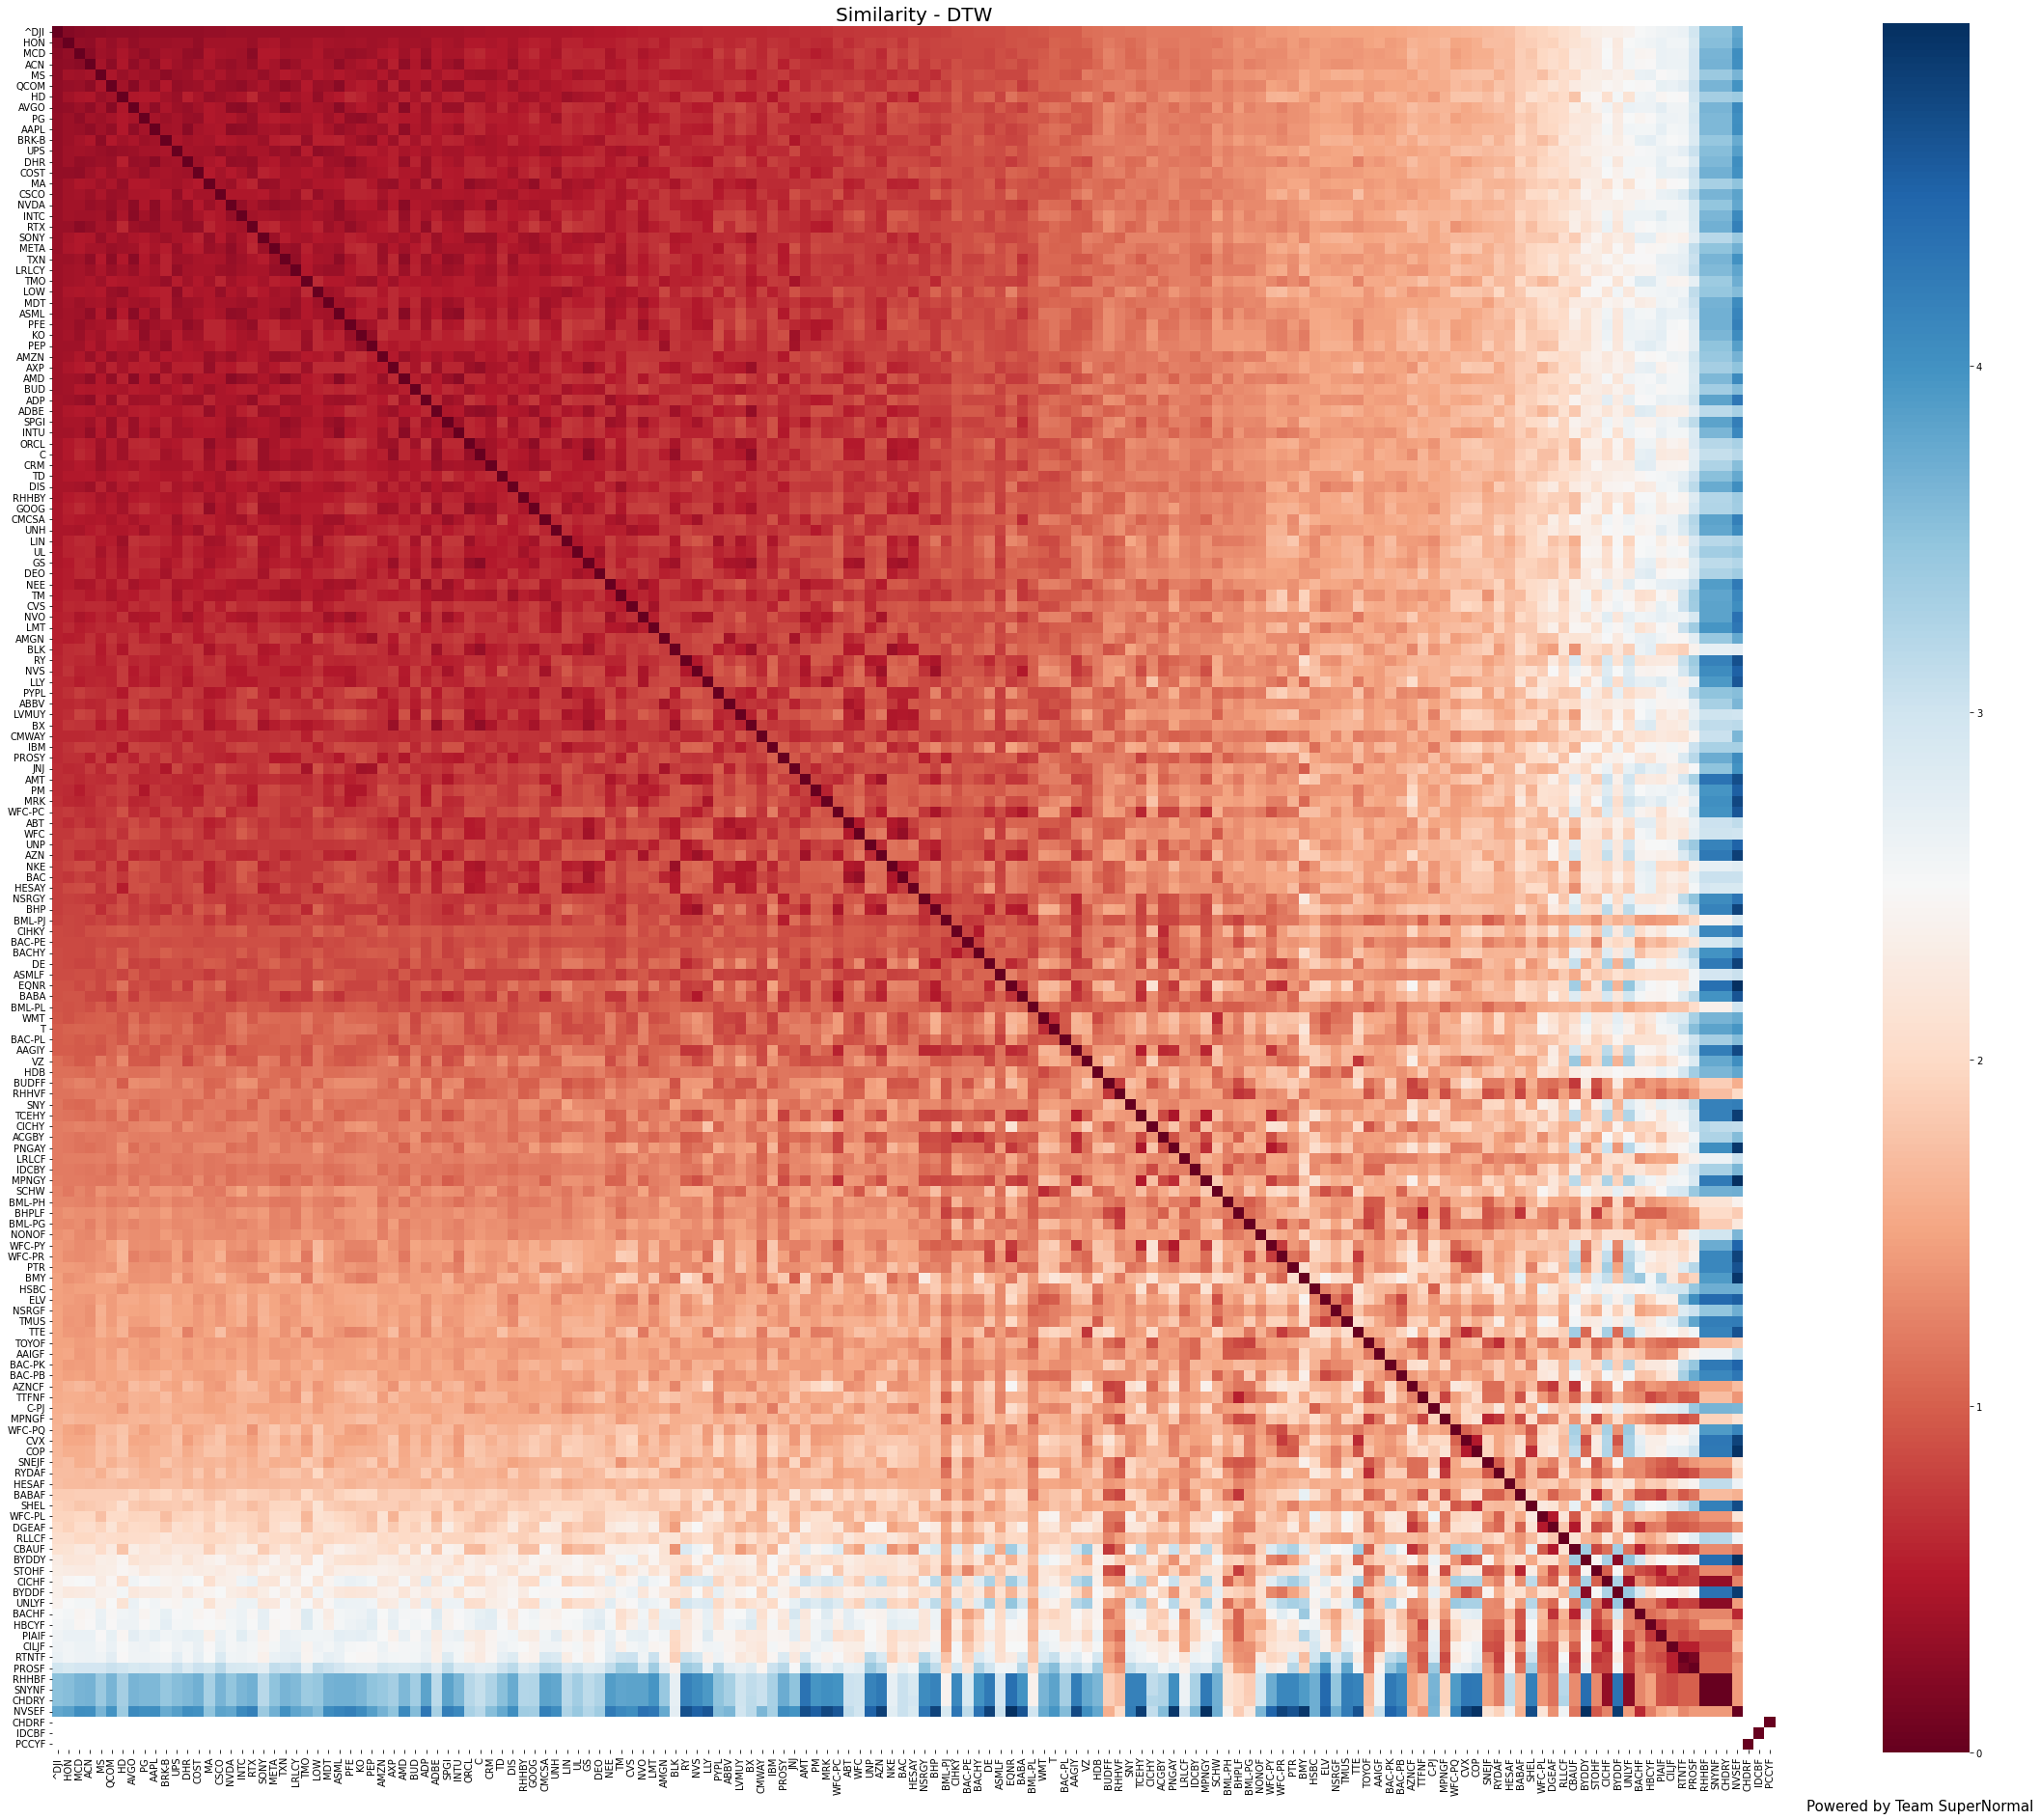

In [34]:
s = heatmap_hero(dji_datas, period='3d', interval='15m', annot= False)

In [37]:
# 挑選前50高的並畫圖，因為有些資料無法正常下載，所以多取幾個股票，但就是畫16筆而已
dji = s['^DJI'].dropna()
check = " ".join(dji.tail(50).iloc[::-1].index)
check = "^DJI " + check
check

'^DJI NVSEF RHHBF CHDRY SNYNF PROSF RTNTF CILJF PIAIF HBCYF BACHF UNLYF BYDDF CICHF STOHF BYDDY CBAUF RLLCF DGEAF WFC-PL SHEL BABAF HESAF RYDAF SNEJF COP CVX WFC-PQ MPNGF C-PJ TTFNF AZNCF BAC-PB BAC-PK AAIGF TOYOF TTE TMUS NSRGF ELV HSBC BMY PTR WFC-PR WFC-PY NONOF BML-PG BHPLF BML-PH SCHW MPNGY'

[*********************100%***********************]  51 of 51 completed


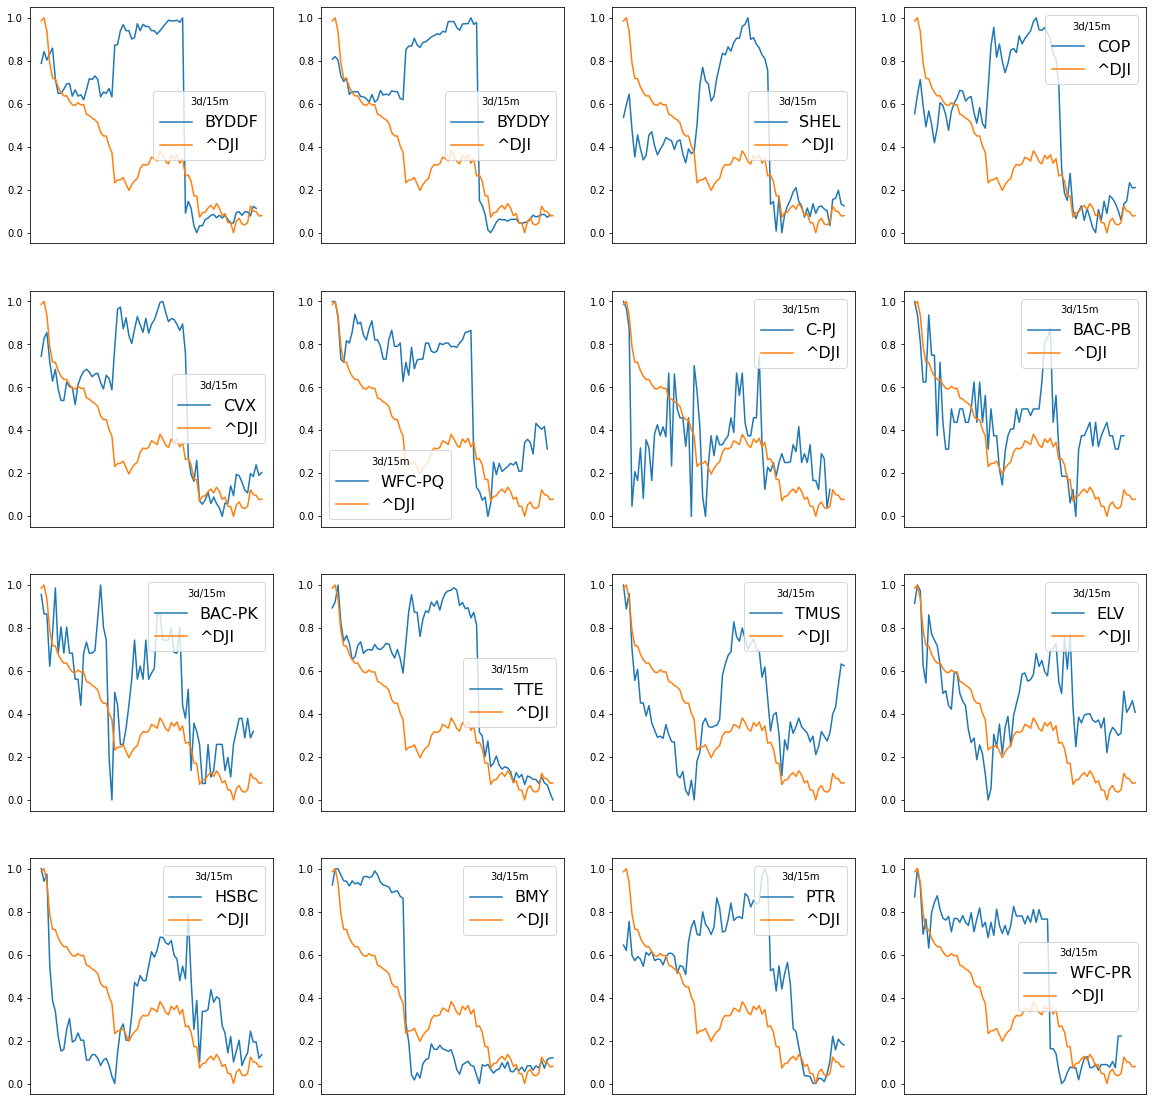

In [44]:
plot_hero_stock(check, period='3d', interval='15m')

[*********************100%***********************]  51 of 51 completed


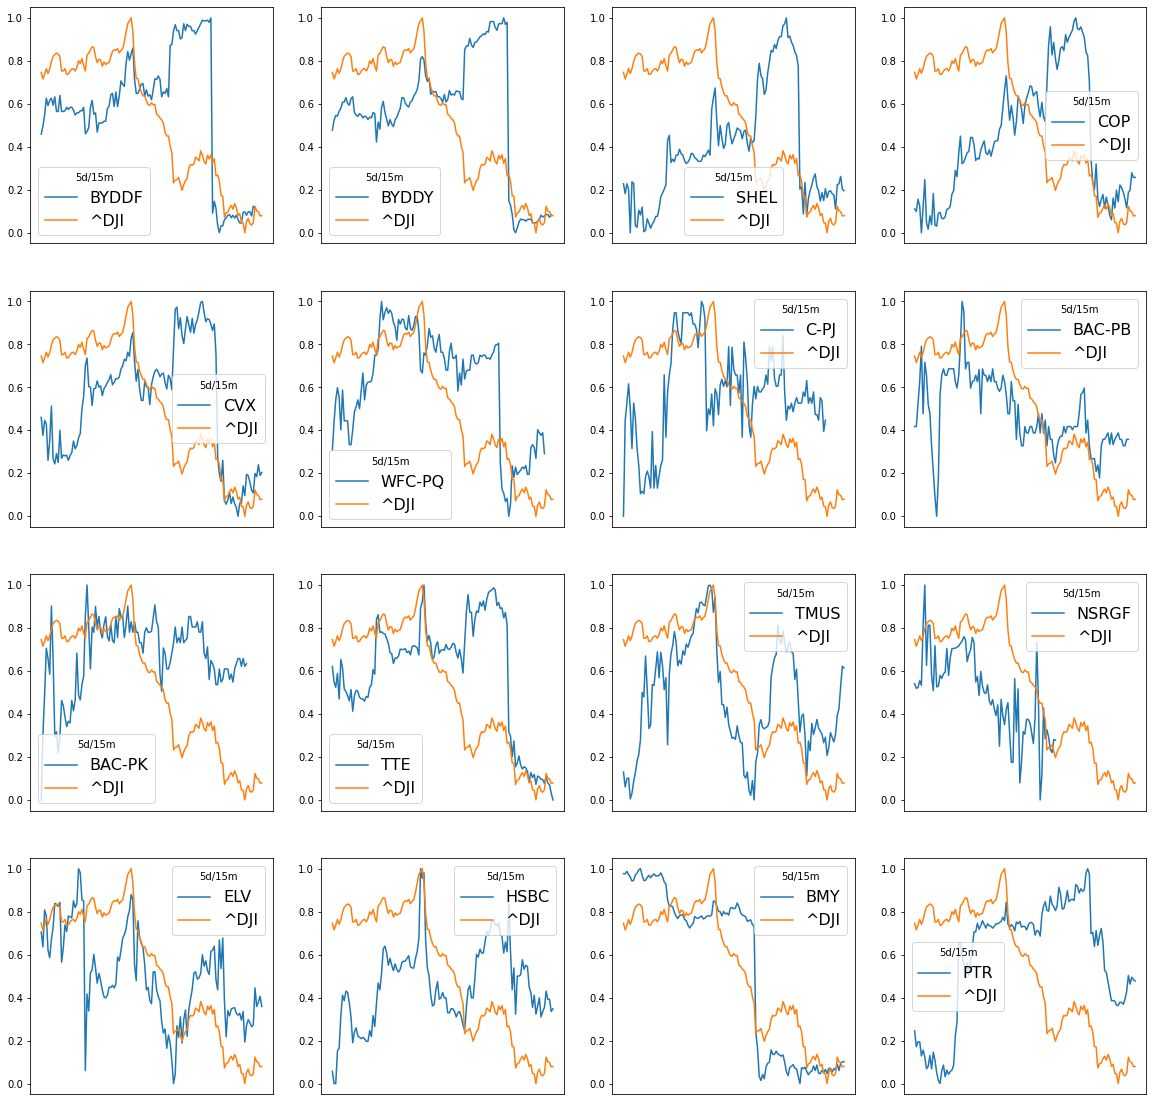

In [43]:
plot_hero_stock(check, period='5d', interval='15m')